In [10]:
import rioxarray as rix
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import shape
from shapely.ops import unary_union
import geopandas as gpd

In [11]:
def open_and_extract_date_from_filename(filepath):
    ds = rix.open_rasterio(filepath)
    ds.attrs['original_filename'] = os.path.basename(filepath)
    ds.attrs['date'] = os.path.basename(filepath)[:10]
    return ds

img_2020 = open_and_extract_date_from_filename("/Users/elischwat/Development/data/sublimationofsnow/planet_imagery/gothic-co-meltout-2020_psscene_analytic_sr_udm2/2020-05-02_strip_3365031_composite_file_format.tif")
img_2021 = open_and_extract_date_from_filename("/Users/elischwat/Development/data/sublimationofsnow/planet_imagery/gothic-co-meltout-2021_psscene_analytic_sr_udm2/2021-04-29_strip_4427235_composite_file_format.tif")
img_2022 = open_and_extract_date_from_filename("/Users/elischwat/Development/data/sublimationofsnow/planet_imagery/gothic-co-meltout-2022_psscene_analytic_sr_udm2/2022-05-06_strip_5620315_composite_file_format.tif")
img_2023 = open_and_extract_date_from_filename("/Users/elischwat/Development/data/sublimationofsnow/planet_imagery/gothic-co-meltout-2023_psscene_analytic_sr_udm2/2023-05-16_strip_6512704_composite_file_format.tif")
img_2024 = open_and_extract_date_from_filename("/Users/elischwat/Development/data/sublimationofsnow/planet_imagery/gothic-co-meltout-2024_psscene_analytic_sr_udm2/2024-05-02_strip_7279988_composite_file_format.tif")
img_2025 = open_and_extract_date_from_filename("/Users/elischwat/Development/data/sublimationofsnow/planet_imagery/gothic-co-meltout-2025_psscene_analytic_sr_udm2/2025-04-25_strip_8025643_composite_file_format.tif")

<Axes: >

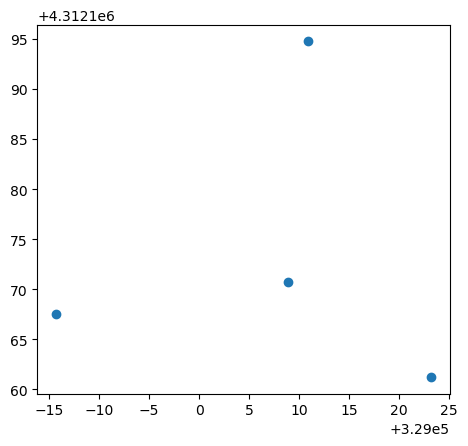

In [14]:
towers_gdf = gpd.read_file("./landsat_data/towers.geojson").to_crs(img_2020.rio.crs)
towers_gdf.plot()

In [15]:
central_point = towers_gdf.set_index('Tower').loc['c'].geometry
from shapely.geometry import box
x, y = central_point.x, central_point.y
bounding_box = gpd.GeoDataFrame(
    geometry = [box(x - 100, y - 100, x + 100, y + 100)],
)
bounding_box

,geometry
0,"POLYGON ((329108.911 4312070.778, 329108.911 4..."


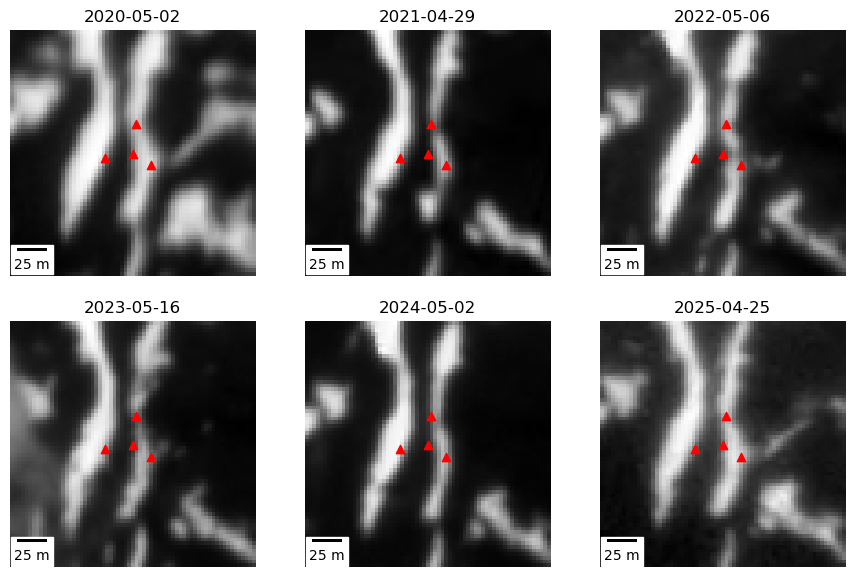

In [16]:
images = [ ('2020', img_2020), ('2021', img_2021), ('2022', img_2022), ('2023', img_2023), ('2024', img_2024), ('2025', img_2025), ]
# Crop all images
cropped_images = [(yr, img.rio.clip(bounding_box.geometry)) for yr, img in images]

# Plot the images in a 3x2 grid
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
axes = axes.flatten()

for ax, (yr, cropped_img) in zip(axes, cropped_images):
    cropped_img.sel(band=1).plot(ax=ax, cmap='grey', add_colorbar=False)
    ax.set_aspect('equal')
    ax.axis('off')  # Remove axis
    ax.set_title(cropped_img.attrs['date'])
    towers_gdf.plot(ax=ax, color='red', marker='^')
    scalebar = ScaleBar(1, location="lower left")
    ax.add_artist(scalebar)

plt.tight_layout()
plt.show()

# ADD LIDAR OUTLINE

In [17]:
ls lidar_data

20230515.tif                    l2_elevation_20230516_1200.tif
20230530.tif                    l2_elevation_20230523_0000.tif
__pycache__/                    l2_elevation_20230523_1200.tif
correct_lidar.py                l2_elevation_20230530_0000.tif
l2_elevation_20230515_0000.tif  lidar_reader.ipynb
l2_elevation_20230515_1200.tif  lvx_reader.py
l2_elevation_20230516_0000.tif  read_dsms.ipynb


In [18]:
lidar = rix.open_rasterio("lidar_data/l2_elevation_20230515_0000.tif")

<Axes: >

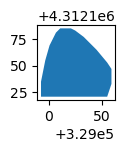

In [19]:
src_raster = rix.open_rasterio('lidar_data/l2_elevation_20230515_0000.tif')
src_raster = src_raster.sel(band=1).astype('float32').rio.reproject(
    src_raster.rio.crs,
    resolution = (2,2)
)
src_raster.rio.to_raster('img.tif')


import rasterio
from rasterio.features import shapes
from shapely.geometry import shape

from geopandas import GeoDataFrame
from pandas import DataFrame


with rasterio.open('img.tif') as src:
    data = src.read(1, masked=True)

    # Use a generator instead of a list
    shape_gen = ((shape(s), v) for s, v in shapes(data, transform=src.transform))

    # either build a pd.DataFrame
    # df = DataFrame(shape_gen, columns=['geometry', 'class'])
    # gdf = GeoDataFrame(df["class"], geometry=df.geometry, crs=src.crs)

    # or build a dict from unpacked shapes
    gdf = GeoDataFrame(dict(zip(["geometry", "class"], zip(*shape_gen))), crs=src.crs)

# # Step 3: Perform a union on all geometries
union_geometry = unary_union(gdf.geometry)
# # Step 4: Extract the convex hull
convex_hull = union_geometry.convex_hull

lidar_outline_gdf = gpd.GeoDataFrame(geometry=[convex_hull])
lidar_outline_gdf.plot(figsize=(1,1))

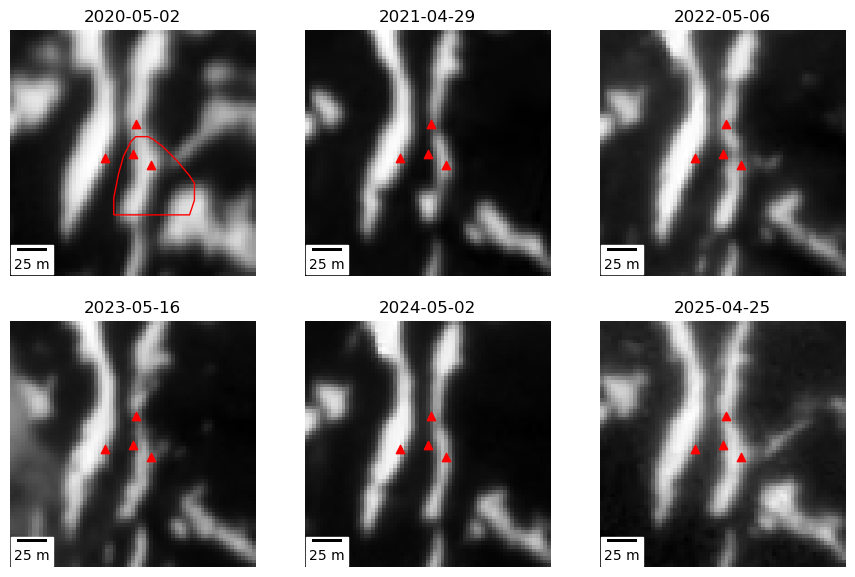

In [52]:
images = [ ('2020', img_2020), ('2021', img_2021), ('2022', img_2022), ('2023', img_2023), ('2024', img_2024), ('2025', img_2025), ]
# Crop all images
cropped_images = [(yr, img.rio.clip(bounding_box.geometry)) for yr, img in images]

# Plot the images in a 3x2 grid
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
axes = axes.flatten()

for ax, (yr, cropped_img) in zip(axes, cropped_images):
    cropped_img.sel(band=1).plot(ax=ax, cmap='grey', add_colorbar=False)
    ax.set_aspect('equal')
    ax.axis('off')  # Remove axis
    ax.set_title(cropped_img.attrs['date'])
    towers_gdf.plot(ax=ax, color='red', marker='^', label='Towers', legend=True)  # Add legend for towers
    scalebar = ScaleBar(1, location="lower left")
    ax.add_artist(scalebar)

lidar_outline_gdf.plot(ax=axes[0], figsize=(1,1), alpha =1.0, edgecolor='red', facecolor='none')
plt.tight_layout()
plt.show()

In [ ]:
lidar_outline_gdf.plot(
    # ax=axes[0], 
    # label='Lidar Outline', 
    column='type',
    alpha=0.25, 
    edgecolor='white', 
    legend=True,
)
plt.legend()

In [ ]:
# # Step 5: Convert the convex hull to a GeoDataFrame for visualization or saving
# convex_hull_gdf = gpd.GeoDataFrame(
#     {"geometry": [convex_hull]},
#     crs=lidar_2x2.rio.crs
# )

# # Save the convex hull to a file (optional)
# convex_hull_gdf.to_file("convex_hull.geojson", driver="GeoJSON")

# # Print the convex hull geometry
# print(convex_hull)